In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import geemap
import ee
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

# 使用的影像总数

In [ ]:
# 大庆市，天津市，武汉市，珠三角，青藏高原
roi1 = ee.Geometry.Rectangle([123.9355, 45.8362,125.3055, 46.8762])
roi2 = ee.Geometry.Rectangle([115.9244, 38.6272,117.4944,39.6372])
roi3 = ee.Geometry.Rectangle([113.7393, 29.8642,115.0993, 30.9242])
roi4 = ee.Geometry.Rectangle([112.7614, 22.2347,114.0514, 23.2547])
roi5 = ee.Geometry.Rectangle([89.8826, 34.6579,91.3626, 35.8279])
roi = ee.FeatureCollection([roi1,roi2,roi3,roi4,roi5])
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,7)

In [ ]:
a = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR').filterBounds(roi).filterDate('2000-01-01', '2020-12-31')
b = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR').filterBounds(roi).filterDate('2000-01-01', '2020-12-31')
c = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(roi).filterDate('2000-01-01', '2020-12-31')
print(a.size().getInfo())
print(b.size().getInfo())
print(c.size().getInfo())
print(a.size().getInfo() + b.size().getInfo() + c.size().getInfo())

# 影像数目的分布，1999-2020，堆积柱状图

In [ ]:
# 大庆市
# roi = ee.Geometry.Rectangle([123.9355, 45.8362,125.3055, 46.8762])
# 天津市
# roi = ee.Geometry.Rectangle([115.9244, 38.6272,117.4944,39.6372])
# 武汉市
# roi = ee.Geometry.Rectangle([113.7393, 29.8642,115.0993, 30.9242])
# 珠三角
# roi = ee.Geometry.Rectangle([112.7614, 22.2347,114.0514, 23.2547])
# 青藏高原
roi = ee.Geometry.Rectangle([89.8826, 34.6579,91.3626, 35.8279])
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,7)

In [ ]:
a = ee.List.sequence(1999,2020,1)
# landsat5
def l5(year):
    start = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-01-01'))
    end = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-12-31'))
    dataset = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR').filterBounds(roi).filterDate(start, end)
    return dataset.size()
print(a.map(l5).getInfo())

# landsat7
def l7(year):
    start = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-01-01'))
    end = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-12-31'))
    dataset = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR').filterBounds(roi).filterDate(start, end)
    return dataset.size()
print(a.map(l7).getInfo())

# landsat8
def l8(year):
    start = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-01-01'))
    end = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-12-31'))
    dataset = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(roi).filterDate(start, end)
    return dataset.size()
print(a.map(l8).getInfo())

In [ ]:
a = ee.List.sequence(1999,2020,1)
l5 = a.map(l5).getInfo()
l7 = a.map(l7).getInfo()
l8 = a.map(l8).getInfo()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
x = np.arange(1999,2021)
plt.figure(figsize=(8, 6))
plt.bar(x, l5, width=0.45,align="center",label="Landsat5")
plt.bar(x, l7, width=0.45, align="center", bottom=l5, label="Landsat7")
plt.bar(x, l8, width=0.45, align="center", bottom=l7, label="Landsat8")

plt.ylim(0,280)
plt.xlabel("Year",size=18)
plt.ylabel("Number of images",size=18)
plt.tick_params(labelsize=15)
plt.xticks([2000,2005,2010,2015,2020])
plt.yticks([50,100,150,200,250])
# plt.legend(prop={'size':13})
plt.title('(e)      Region E',size=20)

plt.show()

# 有效像元分布，2000-2020

## 计算

In [ ]:
# 大庆市
# roi = ee.Geometry.Rectangle([123.9355, 45.8362,125.3055, 46.8762])
# 天津市
# roi = ee.Geometry.Rectangle([115.9244, 38.6272,117.4944,39.6372])
# 武汉市
roi = ee.Geometry.Rectangle([113.7393, 29.8642,115.0993, 30.9242])
# 珠三角
# roi = ee.Geometry.Rectangle([112.7614, 22.2347,114.0514, 23.2547])
# 青藏高原
# roi = ee.Geometry.Rectangle([89.8826, 34.6579,91.3626, 35.8279])
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,7)

In [ ]:
region = 'wuhan'
elevation = ee.Image("users/311605001111/hillshade_" + region)
def maskSR(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    outlier = bands.gt(0).remap([0,1],[1,0]).rename('outlier')
    return img.updateMask(mask).updateMask(ee.Terrain.hillShadow(elevation,azimuth,zenith,200,True)).updateMask(outlier)

In [ ]:
# # 移除无效像元
# elevation = ee.Image('USGS/SRTMGL1_003').select('elevation').clip(roi)
# def maskSR(image):
#     cloudShadowBitMask = (1 << 3)
#     cloudsBitMask = (1 << 5)
#     snowBitMask = (1 << 4)   
#     qa = image.select('pixel_qa')
#     mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
#                    .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
#                    .And(qa.bitwiseAnd(snowBitMask).eq(0))
#     azimuth = image.get('SOLAR_AZIMUTH_ANGLE')
#     zenith = image.get('SOLAR_ZENITH_ANGLE')
#     return image.updateMask(mask).updateMask(ee.Terrain.hillShadow(elevation,azimuth,zenith,200,True))
# # 图像可视化参数
# visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}


# # 移除无效像元
# def maskSR(image):
#     cloudShadowBitMask = (1 << 3)
#     cloudsBitMask = (1 << 5)  
#     qa = image.select('pixel_qa')
#     mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
#              .And(qa.bitwiseAnd(cloudsBitMask).eq(0))
#     return image.updateMask(mask)
# # 图像可视化参数
# visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}

In [ ]:
l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
       .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi) \
       .filterDate('2013-01-01', '2020-12-31') 
l7 = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR') \
       .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi) \
       .filterDate('1999-01-01', '2020-12-31')        
l5 = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
       .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi) \
       .filterDate('1999-01-01', '2012-12-31')
print(l8.size().getInfo())
print(l7.size().getInfo())
print(l5.size().getInfo())

landsat_images =l8.merge(l7).merge(l5)
print(landsat_images.size().getInfo())

validPixel = ee.ImageCollection(landsat_images).map(maskSR).count().select('B3').clip(roi).rename('count')
Map.addLayer(validPixel, {'palette':['white','blue'],'min':0,'max':1000},'validPixel')

In [ ]:
task = ee.batch.Export.image.toAsset(**{
    'image': validPixel,
    'description': region,
    'assetId': 'users/311605001111/validPixel_' + region,
    'scale': 30,
    'region': roi,
    'maxPixels':1e13,
})
task.start()

## 制图

{'count_max': 1198, 'count_min': 36}


Text(0.5, 1.0, '(a)        Region A')

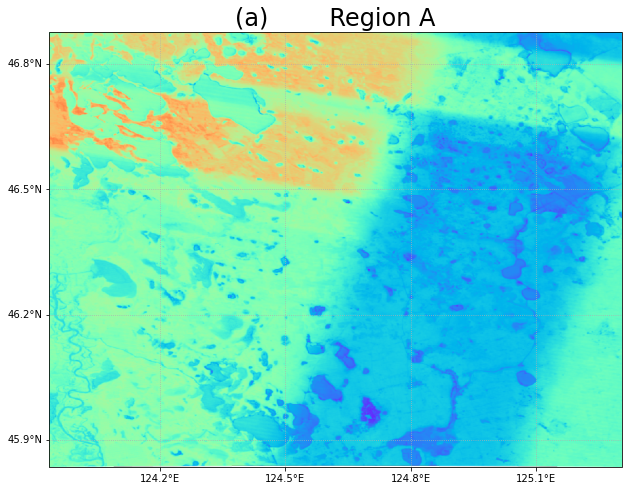

In [14]:
## 大庆
# validPixel = ee.Image('users/311605001111/validPixel_daqing' + 'v2')
validPixel = ee.Image('users/311605001111/valid_pixels_distribution/validPixel_daqing9920')
roi = ee.Geometry.Rectangle([123.9355, 45.8362,125.3055, 46.8762])
minmax = validPixel.reduceRegion(**{
    'reducer': ee.Reducer.minMax(),
    'geometry': roi,
    'scale': 30,
    'maxPixels': 1e14,
})
print(minmax.getInfo())

# 有效像元
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [125.3055, 45.8362, 123.9355, 46.8762]
fig = plt.figure(figsize=(12, 8))
visParams = {'min': 0.0,'max': 1400}

ax = cartoee.get_map(validPixel,cmap="rainbow",region=region,vis_params=visParams)
# cartoee.add_colorbar(ax,vis_params=visParams,cmap="rainbow",loc="right",label="number",orientation="vertical")
cartoee.add_gridlines(ax, interval=[0.3,0.3], linestyle=":")
ax.set_title(label = '(a)        Region A', fontsize=24)

{'count_max': 1347, 'count_min': 166}


Text(0.5, 1.0, '(b)        Region B')

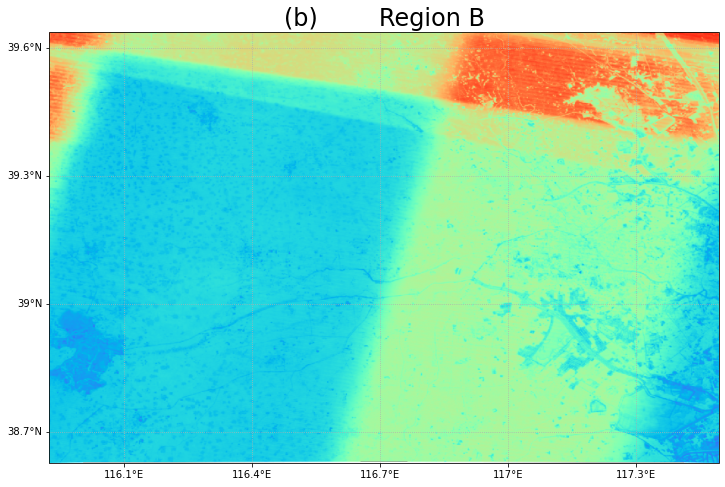

In [15]:
## 天津
validPixel = ee.Image('users/311605001111/valid_pixels_distribution/validPixel_tianjin9920')
roi = ee.Geometry.Rectangle([115.9244, 38.6272,117.4944,39.6372])
minmax = validPixel.reduceRegion(**{
    'reducer': ee.Reducer.minMax(),
    'geometry': roi,
    'scale': 30,
    'maxPixels': 1e14,
})
print(minmax.getInfo())

# 有效像元
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [117.4944, 38.6272, 115.9244, 39.6372]
fig = plt.figure(figsize=(12, 8))
visParams = {'min': 0.0,'max': 1400}

ax = cartoee.get_map(validPixel,cmap="rainbow",region=region,vis_params=visParams)
# cartoee.add_colorbar(ax,vis_params=visParams,cmap="rainbow",loc="right",label="number",orientation="vertical")
cartoee.add_gridlines(ax, interval=[0.3,0.3], linestyle=":")
ax.set_title(label = '(b)        Region B', fontsize=24)

{'count_max': 905, 'count_min': 24}


Text(0.5, 1.0, '(c)        Region C')

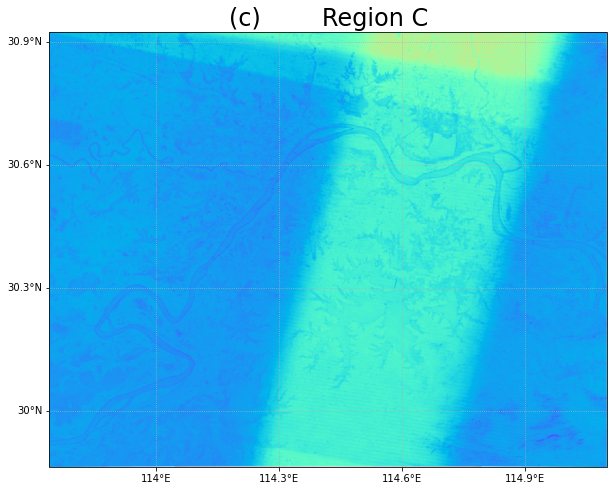

In [16]:
## 武汉
validPixel = ee.Image('users/311605001111/valid_pixels_distribution/validPixel_wuhan9920')
roi = ee.Geometry.Rectangle([113.7393, 29.8642,115.0993, 30.9242])
minmax = validPixel.reduceRegion(**{
    'reducer': ee.Reducer.minMax(),
    'geometry': roi,
    'scale': 30,
    'maxPixels': 1e14,
})
print(minmax.getInfo())

# 有效像元
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [115.0993, 29.8642, 113.7393, 30.9242] 
fig = plt.figure(figsize=(12, 8))
visParams = {'min': 0.0,'max': 1400}

ax = cartoee.get_map(validPixel,cmap="rainbow",region=region,vis_params=visParams)
# cartoee.add_colorbar(ax,vis_params=visParams,cmap="rainbow",loc="right",label="number",orientation="vertical")
cartoee.add_gridlines(ax, interval=[0.3,0.3], linestyle=":")
ax.set_title(label = '(c)        Region C', fontsize=24)

{'count_max': 822, 'count_min': 35}


Text(0.5, 1.0, '(d)        Region D')

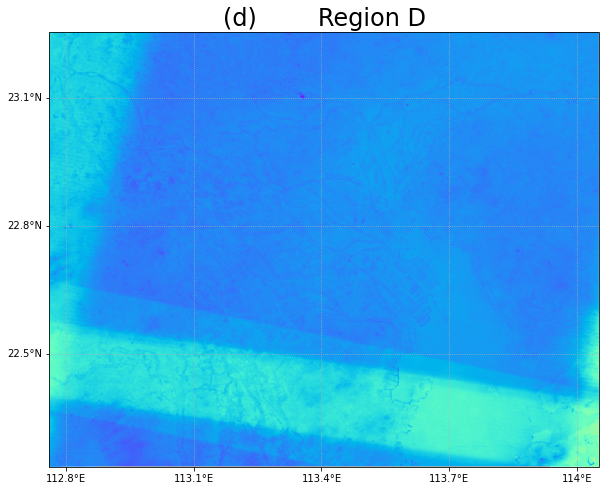

In [17]:
## 珠三角
validPixel = ee.Image('users/311605001111/valid_pixels_distribution/validPixel_prd9920')
roi = ee.Geometry.Rectangle([112.7614, 22.2347,114.0514, 23.2547])
minmax = validPixel.reduceRegion(**{
    'reducer': ee.Reducer.minMax(),
    'geometry': roi,
    'scale': 30,
    'maxPixels': 1e14,
})
print(minmax.getInfo())

# 有效像元
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [114.0514, 22.2347, 112.7614, 23.2547] 
fig = plt.figure(figsize=(12, 8))
visParams = {'min': 0.0,'max': 1400}

ax = cartoee.get_map(validPixel,cmap="rainbow",region=region,vis_params=visParams)
# cartoee.add_colorbar(ax,vis_params=visParams,cmap="rainbow",loc="right",label="number",orientation="vertical")
cartoee.add_gridlines(ax, interval=[0.3,0.3], linestyle=":")
ax.set_title(label = '(d)        Region D', fontsize=24)

{'count_max': 1227, 'count_min': 1}


Text(0.5, 1.0, '(e)        Region E')

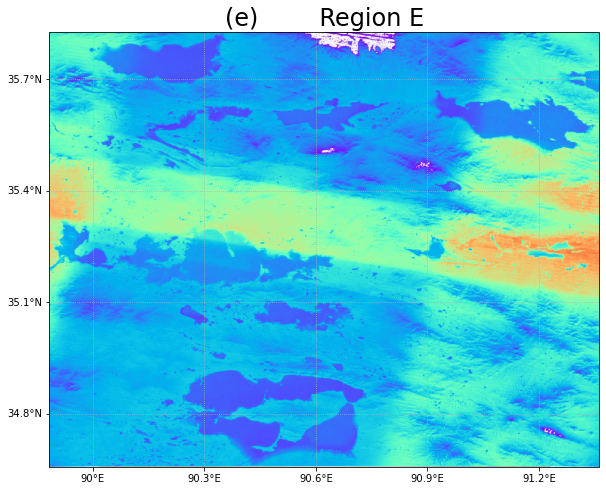

In [18]:
## 青藏高原
validPixel = ee.Image('users/311605001111/valid_pixels_distribution/validPixel_tibet9920')
roi = ee.Geometry.Rectangle([89.8826, 34.6579,91.3626, 35.8279])
minmax = validPixel.reduceRegion(**{
    'reducer': ee.Reducer.minMax(),
    'geometry': roi,
    'scale': 30,
    'maxPixels': 1e14,
})
print(minmax.getInfo())

# 有效像元
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [91.3626, 34.6579, 89.8826, 35.8279]
fig = plt.figure(figsize=(12, 8))
visParams = {'min': 0.0,'max': 1400}

ax = cartoee.get_map(validPixel,cmap="rainbow",region=region,vis_params=visParams)
# cartoee.add_colorbar(ax,vis_params=visParams,cmap="rainbow",loc="right",label="number",orientation="vertical")
cartoee.add_gridlines(ax, interval=[0.3,0.3], linestyle=":")
ax.set_title(label = '(e)        Region E', fontsize=24)